In [35]:
import pandas as pd
pd.options.display.max_columns=200
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
import warnings 
warnings.filterwarnings('ignore')
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error,\
      mean_squared_log_error, mean_absolute_error, make_scorer, r2_score
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.compose import TransformedTargetRegressor
from sklearn.svm import SVR
from scipy.stats import skew
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
import shap

In [36]:
data = pd.read_csv('data.csv')

In [37]:
data.set_index('OSEBuildingID', inplace = True)

In [38]:
data =data[~data.isin([np.nan, np.inf, -np.inf]).any(1)]

In [39]:
cols = ['Age','PropertyGFATotal',
       'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)',
       'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)',
       'LargestPropertyUseTypeGFA','ENERGYSTARScore', 'TotalGHGEmissions']

Age
0.29753360879193896


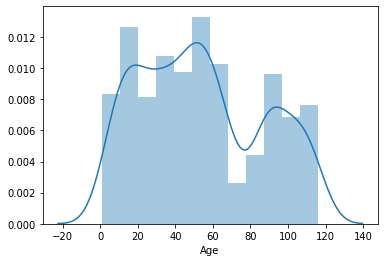

PropertyGFATotal
19.037917545145827


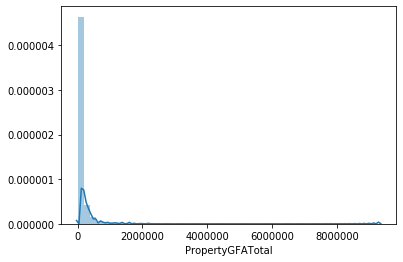

SiteEUI(kBtu/sf)
3.7671810028739445


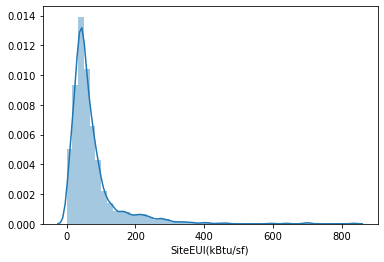

SiteEUIWN(kBtu/sf)
3.668698831817905


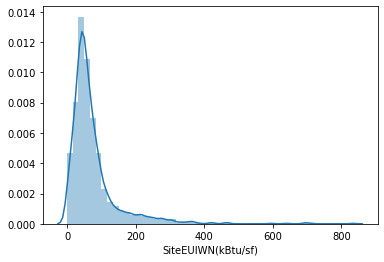

SourceEUI(kBtu/sf)
5.02139873400849


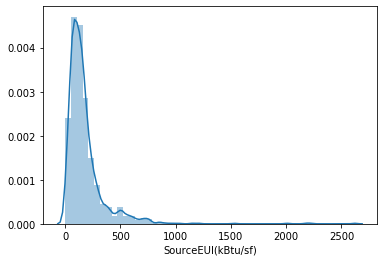

SourceEUIWN(kBtu/sf)
4.998804175082916


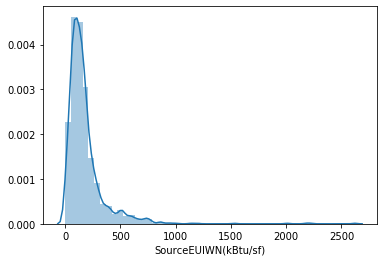

SiteEnergyUse(kBtu)
17.973308078803022


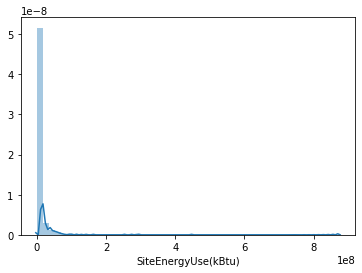

SiteEnergyUseWN(kBtu)
11.278921136571357


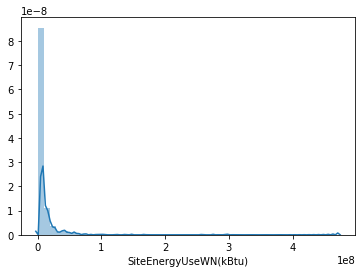

LargestPropertyUseTypeGFA
23.175161728669494


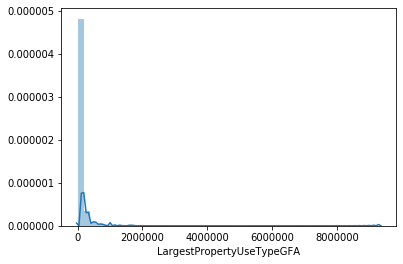

ENERGYSTARScore
0.07727154779048637


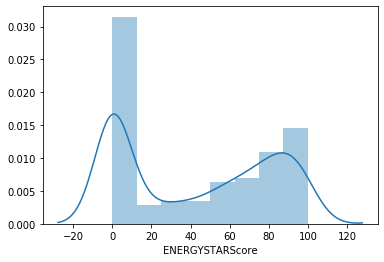

TotalGHGEmissions
14.130616835139792


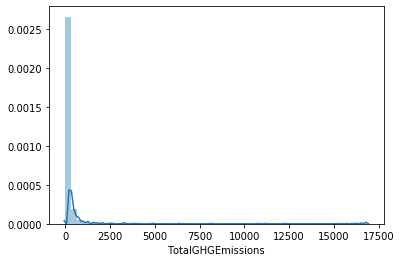

In [40]:
for col in cols:
      print(col)
      print(skew(data[col]))

      plt.figure()
      sns.distplot(data[col])
      plt.show()

In [41]:
cols = ['PropertyGFATotal','PropertyGFAParking(%)',
        'PropertyGFABuilding(s)(%)','PropertyGFATotal',
        'LargestPropertyUseTypeGFA','ENERGYSTARScore', 'TotalGHGEmissions']

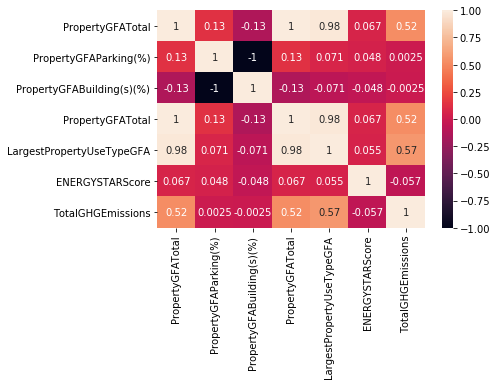

In [42]:
sns.heatmap(data[cols].corr(), annot = True)

In [43]:
X = data[['Age','NumberofBuildings','NumberofFloors','PropertyGFATotal','PropertyGFAParking(%)',
        'PropertyGFABuilding(s)(%)','LargestPropertyUseTypeGFA','ENERGYSTARScore','EnergyStarNaN',
        'PrimaryPropertyType_Distribution Center', 'PrimaryPropertyType_Hotel',
       'PrimaryPropertyType_K-12 School', 
       'PrimaryPropertyType_Large Office',
       'PrimaryPropertyType_Medical Office',
       'PrimaryPropertyType_Mixed Use Property',
       'PrimaryPropertyType_Other',
       'PrimaryPropertyType_Retail Store',
       'PrimaryPropertyType_Self-Storage Facility',
       'PrimaryPropertyType_Small- and Mid-Sized Office',
       'PrimaryPropertyType_Supermarket / Grocery Store',
       'PrimaryPropertyType_University', 'PrimaryPropertyType_Warehouse',
       'PrimaryPropertyType_Worship Facility','CouncilDistrictCode_1',
       'CouncilDistrictCode_2', 'CouncilDistrictCode_3',
       'CouncilDistrictCode_4', 'CouncilDistrictCode_5',
       'CouncilDistrictCode_6', 'CouncilDistrictCode_7']]


y = data['TotalGHGEmissions']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
colsk = ['NumberofFloors','PropertyGFATotal','LargestPropertyUseTypeGFA']

In [46]:
colsk = ['Age','PropertyGFATotal', 'LargestPropertyUseTypeGFA','ENERGYSTARScore']
X_train_tt = X_train.copy()
X_test_tt = X_test.copy()
X_train_tt[colsk] = np.log1p(X_train_tt[colsk])
X_test_tt[colsk] = np.log1p(X_test_tt[colsk])

In [47]:
std_scale = StandardScaler()
std_scale.fit(X_train)
X_train = std_scale.transform(X_train)
X_test = std_scale.transform(X_test)
std_scale_tt = StandardScaler()
std_scale_tt.fit(X_train_tt)
X_train_tt = std_scale_tt.transform(X_train_tt)
X_test_tt = std_scale_tt.transform(X_test_tt)

In [48]:
X_train = pd.DataFrame(X_train, columns = X.columns)
X_test = pd.DataFrame(X_test, columns = X.columns)
X_train_tt = pd.DataFrame(X_train_tt, columns = X.columns)
X_test_tt = pd.DataFrame(X_test_tt, columns = X.columns)

In [50]:
dr = DummyRegressor(strategy="mean")
dr.fit(X_train, y_train)
baseline_error = mean_squared_error(y_test, dr.predict(y_test), squared=False)
baseline_error

770.5687305972889

In [51]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_error = mean_squared_error(y_test, lr.predict(X_test), squared=False)
lr_error

614.7720113903748

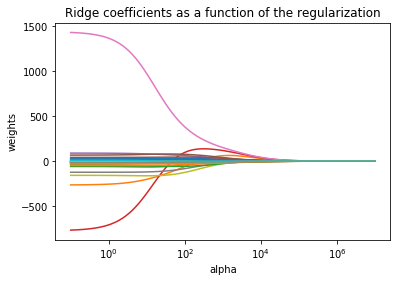

In [52]:
n_alphas = 100
alphas = np.logspace(-1, 7, n_alphas)

ridge = Ridge()

coefs = []
errors = []
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)
    errors.append([baseline_error, mean_squared_error(y_test, ridge.predict(X_test), squared=False)])

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

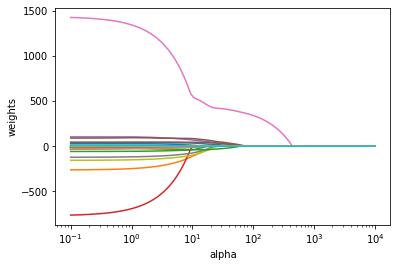

In [53]:
n_alphas = 100
alphas = np.logspace(-1, 4, n_alphas)
lasso = Lasso(fit_intercept=False)

coefs = []
errors = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)
    errors.append([baseline_error, np.mean((lasso.predict(X_test) - y_test) ** 2)])


ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.axis('tight')
plt.show()

In [54]:
def resultize(grid):

    res = pd.DataFrame(grid.cv_results_)
    res = res[['params', 'mean_test_RMSE', 'rank_test_RMSE', 'mean_test_MSE', 'rank_test_MSE', 'mean_test_MAE', 'rank_test_MAE', 'mean_test_R2', 'rank_test_R2']]
    res['mean_test_MSE'] = (-res[f'mean_test_MSE'])
    res['mean_test_RMSE'] = (-res[f'mean_test_RMSE'])
    res['mean_test_MAE'] = (-res[f'mean_test_MAE'])
    res.sort_values(by='rank_test_RMSE', inplace=True)
    return res

In [55]:
s = {'MSE': 'neg_mean_squared_error', 
      'RMSE': 'neg_root_mean_squared_error',
      'MAE': 'neg_mean_absolute_error',
      'R2': 'r2'}
score = 'RMSE'

In [56]:
params = {'alpha': np.logspace(0, 7, 20)}
grid_ridge = GridSearchCV(Ridge(), params, cv = 10, 
                  scoring = s, refit = score, n_jobs=-1)
grid_ridge.fit(X_train, y_train)
grid_ridge_best_params = grid_ridge.best_params_
resultize(grid_ridge).head()

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
8,{'alpha': 885.8667904100823},476.639195,1,391733.232026,1,158.033462,1,0.174566,2
7,{'alpha': 379.26901907322497},499.014277,2,399812.073361,2,166.462100,2,0.098645,4
9,{'alpha': 2069.138081114788},516.894437,3,430045.350869,3,167.498079,3,0.175937,1
10,{'alpha': 4832.930238571752},554.135987,4,478036.314766,4,181.645970,4,0.121211,3
6,{'alpha': 162.3776739188721},558.543953,5,487951.291381,5,183.185330,5,-0.068267,7


In [57]:
grid_ridge_best_params ={'alpha': 885.8667904100823}

In [58]:
ridge = Ridge(**grid_ridge_best_params)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
ridge_error = mean_squared_error(y_test, y_pred, squared=False)
ridge_error

672.8791568764291

In [59]:
params = {"alpha": np.logspace(-1, 3, 30)}
grid_lasso = GridSearchCV(Lasso(), params, cv = 10, 
                  scoring = s, refit = score, n_jobs=-1)
grid_lasso.fit(X_train, y_train)
grid_lasso_best_params = grid_lasso.best_params_
resultize(grid_lasso).head()

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
22,{'alpha': 108.2636733874054},482.539769,1,390921.906220,2,166.906055,3,0.155596,1
21,{'alpha': 78.80462815669912},488.342255,2,390012.762722,1,165.871353,2,0.137284,3
20,{'alpha': 57.361525104486816},512.534425,3,409277.421348,3,165.864468,1,0.111911,4
23,{'alpha': 148.73521072935117},519.468991,4,423490.886398,4,174.215708,6,0.142675,2
19,{'alpha': 41.753189365604},549.353859,5,468634.669624,5,168.319308,4,0.054916,6


In [60]:
grid_lasso_best_params = {'alpha': 108.2636733874054}

In [61]:
lasso = Lasso(**grid_lasso_best_params)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
lasso_error = mean_squared_error(y_test, y_pred, squared=False)
lasso_error

681.1888577167889

In [62]:
"""tt_ridge = TransformedTargetRegressor(regressor = Ridge(),
                               func = np.log1p,
                               inverse_func = np.expm1)
params = {'regressor__alpha': np.logspace(0, 7, 100)}
grid_tt_ridge = GridSearchCV(tt_ridge, scoring=s, refit = score, param_grid=params, cv = 10)
grid_tt_ridge.fit(X_train_tt, y_train)
grid_tt_ridge_best_params = grid_tt_ridge.best_params_
resultize(grid_tt_ridge).head()"""
#10s

"tt_ridge = TransformedTargetRegressor(regressor = Ridge(),\n                               func = np.log1p,\n                               inverse_func = np.expm1)\nparams = {'regressor__alpha': np.logspace(0, 7, 100)}\ngrid_tt_ridge = GridSearchCV(tt_ridge, scoring=s, refit = score, param_grid=params, cv = 10)\ngrid_tt_ridge.fit(X_train_tt, y_train)\ngrid_tt_ridge_best_params = grid_tt_ridge.best_params_\nresultize(grid_tt_ridge).head()"

In [63]:
grid_tt_ridge_best_params = {'alpha': 413.20124001153346}

In [64]:
tt_ridge = TransformedTargetRegressor(regressor = Ridge(**grid_tt_ridge_best_params),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt_ridge.fit(X_train_tt, y_train)
y_pred = tt_ridge.predict(X_test_tt)
tt_ridge_error = mean_squared_error(y_test, y_pred, squared=False)
tt_ridge_error

700.6454542940965

In [28]:
tt_lasso = TransformedTargetRegressor(regressor = Lasso(),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__alpha': np.logspace(-1, 3, 30)}
grid_tt_lasso = GridSearchCV(tt_lasso, scoring=s, refit = score, param_grid=params, cv = 10)
grid_tt_lasso.fit(X_train_tt, y_train)
grid_tt_lasso_best_params = grid_tt_lasso.best_params_
resultize(grid_tt_lasso).head()

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
1,{'regressor__alpha': 0.1373823795883263},615.054720,1,575334.088455,2,154.215587,2,0.027574,1
2,{'regressor__alpha': 0.18873918221350972},616.212353,2,575120.913624,1,155.208703,3,0.013224,3
0,{'regressor__alpha': 0.1},616.501047,3,578332.669582,4,153.792395,1,0.026572,2
3,{'regressor__alpha': 0.2592943797404667},619.937909,4,577916.425811,3,157.671034,4,-0.013550,4
4,{'regressor__alpha': 0.3562247890262442},623.603543,5,580902.075530,5,161.424240,5,-0.040006,5


In [65]:
grid_tt_lasso_best_params = {'alpha': 0.1373823795883263}

In [66]:
tt_lasso = TransformedTargetRegressor(regressor = Lasso(**grid_tt_lasso_best_params),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt_lasso.fit(X_train_tt, y_train)
y_pred = tt_lasso.predict(X_test_tt)
tt_lasso_error = mean_squared_error(y_test, y_pred, squared=False)
tt_lasso_error

726.6231826330019

In [67]:
params = {'kernel': ['sigmoid','rbf','poly'],
         'C': [0.1,1,100,1000],
         'degree': [1,2,3,4,5,6]}
grid_svr = GridSearchCV(SVR(), params, cv=10, scoring = s,
                        refit = score,  n_jobs=-1)
grid_svr.fit(X_train, y_train)
best_params_svr = grid_svr.best_params_
resultize(grid_svr).head()

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
56,"{'C': 1000, 'degree': 1, 'kernel': 'poly'}",475.803318,1,395389.542506,1,125.826171,1,0.323142,1
38,"{'C': 100, 'degree': 1, 'kernel': 'poly'}",490.866822,2,411039.931766,2,126.764483,2,0.310659,2
64,"{'C': 1000, 'degree': 4, 'kernel': 'rbf'}",532.779024,3,470455.441298,3,130.545493,3,0.296809,3
67,"{'C': 1000, 'degree': 5, 'kernel': 'rbf'}",532.779024,3,470455.441298,3,130.545493,3,0.296809,3
61,"{'C': 1000, 'degree': 3, 'kernel': 'rbf'}",532.779024,3,470455.441298,3,130.545493,3,0.296809,3


In [69]:
best_params_svr = {'C': 1000, 'degree': 1, 'kernel': 'poly'}

In [70]:
svr = SVR(**best_params_svr)
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)
svr_error = mean_squared_error(y_test, y_pred, squared=False)
svr_error

684.9899041811699

In [71]:
tt_svr = TransformedTargetRegressor(regressor = SVR(),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__C': [0.1,1,100,1000],
            'regressor__degree': [1,2,3,4,5,6]}
grid_tt_svr = GridSearchCV(tt_svr, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_svr.fit(X_train_tt, y_train)
best_params_svr_tt = grid_tt_svr.best_params_
resultize(grid_tt_svr).head()

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
11,"{'regressor__C': 1, 'regressor__degree': 6}",519.613319,1,451702.348298,1,123.434677,1,0.335208,1
10,"{'regressor__C': 1, 'regressor__degree': 5}",519.613319,1,451702.348298,1,123.434677,1,0.335208,1
9,"{'regressor__C': 1, 'regressor__degree': 4}",519.613319,1,451702.348298,1,123.434677,1,0.335208,1
8,"{'regressor__C': 1, 'regressor__degree': 3}",519.613319,1,451702.348298,1,123.434677,1,0.335208,1
7,"{'regressor__C': 1, 'regressor__degree': 2}",519.613319,1,451702.348298,1,123.434677,1,0.335208,1


In [72]:
best_params_svr_tt = {'C': 1, 'degree': 6}

In [73]:
tt_svr = TransformedTargetRegressor(regressor = SVR(**best_params_svr_tt),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt_svr.fit(X_train_tt, y_train)
y_pred = tt_svr.predict(X_test_tt)
tt_svr_error = mean_squared_error(y_test, y_pred, squared=False)
tt_svr_error

537.6017081924447

In [74]:
"""params = {'n_estimators': [100, 200, 300, 400, 500],
            'max_depth': [1,3,5,7,9],
            'min_samples_split': [3,5,7,9],
}
grid_rf = GridSearchCV(RandomForestRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)
grid_rf.fit(X_train, y_train)
best_params_rf = grid_rf.best_params_
resultize(grid_rf).head()"""
#30s

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
95,"{'max_depth': 9, 'min_samples_split': 9, 'n_es...",527.329066,1,414738.233189,1,148.969502,1,-0.334917,27
55,"{'max_depth': 5, 'min_samples_split': 9, 'n_es...",533.696790,2,429751.649126,3,154.179736,42,-0.156649,1
46,"{'max_depth': 5, 'min_samples_split': 5, 'n_es...",538.623595,3,436025.544834,10,154.174331,41,-0.242771,3
85,"{'max_depth': 9, 'min_samples_split': 5, 'n_es...",538.780608,4,426807.989062,2,149.843550,3,-0.228376,2
71,"{'max_depth': 7, 'min_samples_split': 7, 'n_es...",539.002725,5,434158.650741,5,150.571926,7,-0.275091,7


In [76]:
best_params_rf = {'max_depth': 9, 'min_samples_split': 9, 'n_estimators': 100}

In [77]:
rf = RandomForestRegressor(**best_params_rf)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rf_error = mean_squared_error(y_test, y_pred, squared=False)
rf_error

470.97416152145746

In [78]:
"""tt_rf = TransformedTargetRegressor(regressor = RandomForestRegressor(**best_params_rf),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__n_estimators': [100, 200, 300, 400, 500],
            'regressor__max_depth': [1,3,5,7,9],
            'regressor__min_samples_split': [3,5,7,9]}
grid_tt_rf = GridSearchCV(tt_rf, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_rf.fit(X_train_tt, y_train)
best_params_rf_tt = grid_tt_rf.best_params_
resultize(grid_tt_rf).head()"""
#30s

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
96,"{'regressor__max_depth': 9, 'regressor__min_sa...",483.404296,1,394030.220620,3,122.953822,5,0.387593,1
93,"{'regressor__max_depth': 9, 'regressor__min_sa...",483.978817,2,393452.559635,2,123.216689,7,0.381710,2
92,"{'regressor__max_depth': 9, 'regressor__min_sa...",485.014061,3,394931.836444,4,122.794555,1,0.378254,8
99,"{'regressor__max_depth': 9, 'regressor__min_sa...",486.139756,4,397118.332591,11,122.883708,2,0.376223,13
86,"{'regressor__max_depth': 9, 'regressor__min_sa...",486.593632,5,398394.379635,15,123.196575,6,0.379749,4


In [80]:
best_params_rf_tt = {'max_depth': 9,
 'min_samples_split': 9,
 'n_estimators': 200}

In [81]:
rf_tt = TransformedTargetRegressor(
      regressor = RandomForestRegressor(**best_params_rf_tt),
      func = np.log1p,
      inverse_func = np.expm1)
rf_tt.fit(X_train_tt, y_train)
y_pred = rf_tt.predict(X_test_tt)
tt_rf_error = mean_squared_error(y_test, y_pred, squared=False)
tt_rf_error

552.2432236011044

In [82]:
"""params = {'loss': ['ls', 'lad', 'huber', 'quantile'],
            'learning_rate': [0.1, 0.05, 0.02, 0.01],
            'max_depth': [4, 6],
            'min_samples_leaf': [3, 5, 9, 17],
}
grid_gb = GridSearchCV(GradientBoostingRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)
grid_gb.fit(X_train, y_train)
best_params_gb = grid_gb.best_params_
resultize(grid_gb).head()"""
#30s

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
53,"{'learning_rate': 0.05, 'loss': 'huber', 'max_...",448.180338,1,348096.471067,6,119.946152,1,0.461323,1
21,"{'learning_rate': 0.1, 'loss': 'huber', 'max_d...",453.400243,2,344703.770772,4,123.567431,10,0.414326,3
17,"{'learning_rate': 0.1, 'loss': 'huber', 'max_d...",462.098042,3,361460.395813,8,122.148674,4,0.335357,21
52,"{'learning_rate': 0.05, 'loss': 'huber', 'max_...",470.448726,4,360437.135578,7,127.589519,32,0.346220,17
22,"{'learning_rate': 0.1, 'loss': 'huber', 'max_d...",474.644101,5,380758.028070,13,126.587478,31,0.393731,4


In [84]:
best_params_gb = {'learning_rate': 0.05, 'loss': 'huber', 'max_depth': 6, 'min_samples_leaf': 5}

In [85]:
gb = GradientBoostingRegressor(**best_params_gb)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
gb_error = mean_squared_error(y_test, y_pred, squared=False)
gb_error

517.906499211134

In [86]:
'''tt_gb = TransformedTargetRegressor(regressor = GradientBoostingRegressor(),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__loss': ['ls', 'lad', 'huber', 'quantile'],
            'regressor__learning_rate': [0.1, 0.05, 0.02, 0.01],
            'regressor__max_depth': [4, 6],
            'regressor__min_samples_leaf': [3, 5, 9, 17]}
grid_tt_gb = GridSearchCV(tt_gb, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_gb.fit(X_train_tt, y_train)
best_params_gb_tt = grid_tt_gb.best_params_
resultize(grid_tt_gb).head()'''
#30s

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
21,"{'regressor__learning_rate': 0.1, 'regressor__...",403.584854,1,296183.168010,1,112.801645,2,0.525019,1
5,"{'regressor__learning_rate': 0.1, 'regressor__...",419.734207,2,304677.938494,2,115.820215,7,0.463695,9
22,"{'regressor__learning_rate': 0.1, 'regressor__...",420.058906,3,313088.955410,4,112.495095,1,0.523148,2
1,"{'regressor__learning_rate': 0.1, 'regressor__...",420.148243,4,304934.026575,3,114.981310,3,0.488046,3
17,"{'regressor__learning_rate': 0.1, 'regressor__...",433.016571,5,325633.896533,5,115.635786,6,0.462457,10


In [88]:
best_params_gb_tt = {'learning_rate': 0.1,
      'loss': 'huber',
      'max_depth': 6,
      'min_samples_leaf': 5}

In [89]:
gb_tt = TransformedTargetRegressor(GradientBoostingRegressor(**best_params_gb_tt),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
gb_tt.fit(X_train_tt, y_train)
y_pred = gb_tt.predict(X_test_tt)
tt_gb_error = mean_squared_error(y_test, y_pred, squared=False)
tt_gb_error

386.10825728603777

In [90]:
params = {'n_estimators': [100, 200, 300, 400, 500],
            'learning_rate': [0.1, 0.05, 0.02, 0.01],
            'loss': ['linear', 'square', 'exponential'],
}
grid_ad = GridSearchCV(AdaBoostRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)
grid_ad.fit(X_train, y_train)
best_params_ad = grid_ad.best_params_
resultize(grid_ad).head()

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
30,"{'learning_rate': 0.02, 'loss': 'linear', 'n_e...",590.652203,1,513341.272952,1,174.555394,3,-0.307569,2
8,"{'learning_rate': 0.1, 'loss': 'square', 'n_es...",600.087763,2,543978.914039,2,213.634106,48,-0.652179,31
50,"{'learning_rate': 0.01, 'loss': 'square', 'n_e...",611.031233,3,563863.990335,3,170.372781,1,-0.238453,1
55,"{'learning_rate': 0.01, 'loss': 'exponential',...",611.067596,4,566328.527510,4,171.118837,2,-0.409818,7
25,"{'learning_rate': 0.05, 'loss': 'exponential',...",615.203836,5,569806.597300,5,185.493792,16,-0.527617,17


In [92]:
best_params_ad = {'learning_rate': 0.02, 'loss': 'linear', 'n_estimators': 100}

In [93]:
ad = AdaBoostRegressor(**best_params_ad)
ad.fit(X_train, y_train)
y_pred = ad.predict(X_test)
ad_error = mean_squared_error(y_test, y_pred, squared=False)
ad_error

315.6965559804622

In [94]:
'''tt_ad = TransformedTargetRegressor(regressor = AdaBoostRegressor(),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__n_estimators': [100, 200, 300, 400, 500],
            'regressor__learning_rate': [0.1, 0.05, 0.02, 0.01],
            'regressor__loss': ['linear', 'square', 'exponential'],
}
grid_tt_ad = GridSearchCV(tt_ad, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_ad.fit(X_train_tt, y_train)
best_params_ad_tt = grid_tt_ad.best_params_
resultize(grid_tt_ad).head()'''
#30s

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
16,"{'regressor__learning_rate': 0.05, 'regressor_...",523.916078,1,447132.071729,1,135.102297,16,0.281102,1
26,"{'regressor__learning_rate': 0.05, 'regressor_...",528.024194,2,450421.503994,2,135.406343,30,0.266210,7
33,"{'regressor__learning_rate': 0.02, 'regressor_...",529.079929,3,452721.262055,6,135.274919,22,0.266366,5
34,"{'regressor__learning_rate': 0.02, 'regressor_...",529.296229,4,452289.571047,5,135.111536,17,0.265757,8
10,"{'regressor__learning_rate': 0.1, 'regressor__...",529.757034,5,454951.080749,8,133.020483,1,0.275174,2


In [96]:
best_params_ad_tt = {'learning_rate': 0.05,
      'loss': 'linear',
      'n_estimators': 200
      }

In [98]:
tt_ad = TransformedTargetRegressor(regressor=AdaBoostRegressor(**best_params_ad_tt),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt_ad.fit(X_train_tt, y_train)
y_pred = tt_ad.predict(X_test_tt)
tt_ad_error = mean_squared_error(y_test, y_pred, squared=False)
tt_ad_error

609.6457858377518

In [99]:
"""params = {'hidden_layer_sizes': [(100,),(200,),(300,),(400,),(500,)],
            'activation': ['identity', 'logistic', 'tanh', 'relu'],
            'solver': ['lbfgs', 'adam'],
}
grid_mlp = GridSearchCV(MLPRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)
grid_mlp.fit(X_train, y_train)
best_params_mlp = grid_mlp.best_params_
resultize(grid_mlp).head()"""
#1m20s

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
31,"{'activation': 'relu', 'hidden_layer_sizes': (...",491.434395,1,408643.936609,2,165.856645,11,0.011497,12
1,"{'activation': 'identity', 'hidden_layer_sizes...",495.991260,2,408062.355118,1,186.900763,19,-0.027001,13
33,"{'activation': 'relu', 'hidden_layer_sizes': (...",505.598997,3,409089.696083,3,168.954338,12,0.014612,11
3,"{'activation': 'identity', 'hidden_layer_sizes...",525.708584,4,424727.758703,4,195.539206,21,-0.105186,16
35,"{'activation': 'relu', 'hidden_layer_sizes': (...",535.603694,5,453577.782598,5,170.091527,13,-0.028398,14


In [101]:
best_params_mlp = {'activation': 'relu', 'hidden_layer_sizes': (100,), 'solver': 'adam'}

In [102]:
mlp = MLPRegressor(**best_params_mlp)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
mlp_error = mean_squared_error(y_test, y_pred, squared=False)
mlp_error

680.7298842925794

In [103]:
'''tt_mlp = TransformedTargetRegressor(regressor = MLPRegressor(),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__hidden_layer_sizes': [(100,),(200,),(300,),(400,),(500,)],
            'regressor__activation': ['identity', 'logistic', 'tanh', 'relu'],
            'regressor__solver': ['lbfgs', 'adam'],
}
grid_tt_mlp = GridSearchCV(tt_mlp, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_mlp.fit(X_train_tt, y_train)
best_params_tt_mlp = grid_tt_mlp.best_params_
resultize(grid_tt_mlp).head()'''
#1m20s

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
13,"{'regressor__activation': 'logistic', 'regress...",437.384350,1,348709.142268,1,115.081993,5,0.420307,3
21,"{'regressor__activation': 'tanh', 'regressor__...",449.122400,2,367996.604482,2,113.204871,2,0.404558,5
23,"{'regressor__activation': 'tanh', 'regressor__...",450.121190,3,368234.243235,3,112.113470,1,0.437826,1
25,"{'regressor__activation': 'tanh', 'regressor__...",456.058885,4,375123.245145,5,113.874175,3,0.412472,4
29,"{'regressor__activation': 'tanh', 'regressor__...",464.577614,5,377869.269208,6,114.721923,4,0.374909,7


In [105]:
best_params_tt_mlp = {'activation': 'logistic',
      'hidden_layer_sizes': (200,),
      'solver': 'adam'
      }

In [106]:
tt_mlp = TransformedTargetRegressor(regressor=MLPRegressor(**best_params_tt_mlp),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt_mlp.fit(X_train_tt, y_train)
y_pred = tt_mlp.predict(X_test_tt)
tt_mlp_error = mean_squared_error(y_test, y_pred, squared=False)
tt_mlp_error

564.1711821724267

In [107]:
"""xgb = XGBRegressor()
params = {'n_estimators': [100, 200, 300, 400, 500],
            'learning_rate': [0.1, 0.05, 0.02, 0.01],
            'max_depth': [2, 3, 4, 5, 6]}
grid_xgb = GridSearchCV(XGBRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)
grid_xgb.fit(X_train, y_train)
best_params_xgb = grid_xgb.best_params_
resultize(grid_xgb).head()"""
#10mn

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
90,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",551.607971,1,462232.695580,3,136.694325,1,0.188559,1
95,"{'learning_rate': 0.01, 'max_depth': 6, 'n_est...",557.930126,2,472403.714620,6,136.921851,2,0.150274,2
91,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",566.128704,3,451601.500489,1,143.776901,3,-0.056490,6
65,"{'learning_rate': 0.02, 'max_depth': 5, 'n_est...",568.403129,4,454566.875882,2,143.971762,4,-0.081690,7
75,"{'learning_rate': 0.01, 'max_depth': 2, 'n_est...",570.358447,5,490116.697739,8,157.028846,69,0.022232,4


In [109]:
best_params_xgb = {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}

In [110]:
xgb = XGBRegressor(**best_params_xgb)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
xgb_error = mean_squared_error(y_test, y_pred, squared=False)
xgb_error

732.0056455146107

In [111]:
"""tt_xgb = TransformedTargetRegressor(regressor = XGBRegressor(**best_params_xgb),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__n_estimators': [100, 200, 300, 400, 500],
            'regressor__learning_rate': [0.05, 0.02, 0.01],
            'regressor__max_depth': [2, 3, 4, 5, 6]}
grid_tt_xgb = GridSearchCV(tt_xgb, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_xgb.fit(X_train_tt, y_train)
best_params_tt_xgb = grid_tt_xgb.best_params_
resultize(grid_tt_xgb).head()"""
#7mn

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
14,"{'regressor__learning_rate': 0.05, 'regressor_...",439.691790,1,331298.259110,2,116.904631,1,0.405366,8
19,"{'regressor__learning_rate': 0.05, 'regressor_...",439.986088,2,329563.825785,1,117.462822,2,0.415120,5
17,"{'regressor__learning_rate': 0.05, 'regressor_...",444.592342,3,335806.960802,4,118.098977,4,0.420456,4
18,"{'regressor__learning_rate': 0.05, 'regressor_...",445.450103,4,335357.380511,3,118.152665,5,0.403717,10
13,"{'regressor__learning_rate': 0.05, 'regressor_...",446.149926,5,339508.505913,5,117.886222,3,0.400631,13


In [113]:
best_params_tt_xgb = {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 500}

In [114]:
tt_xgb = TransformedTargetRegressor(regressor=XGBRegressor(**best_params_tt_xgb),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt_xgb.fit(X_train_tt, y_train)
y_pred = tt_xgb.predict(X_test_tt)
tt_xgb_error = mean_squared_error(y_test, y_pred, squared=False)
tt_xgb_error

387.6975445591075

In [115]:
errors = {'Baseline': baseline_error,
            'Linear Regression': lr_error,
            'Ridge': ridge_error,
            'Ridge_tt': tt_ridge_error,
            'Lasso': lasso_error,
            'Lasso_tt': tt_lasso_error,
            'SVR': svr_error,
            'SVR_tt': tt_svr_error,
            'Random Forest': rf_error,
            'Random Forest_tt': tt_rf_error,
            'Gradient Boosting': gb_error,
            'Gradient Boosting_tt': tt_gb_error,
            'AdaBoost': ad_error,
            'AdaBoost_tt': tt_ad_error,
            'MLP': mlp_error,
            'MLP_tt': tt_mlp_error,
            'XGBoost': xgb_error,
            'XGBoost_tt': tt_xgb_error
}

In [116]:
#Classement des erreurs
errors = pd.DataFrame(errors.items(), columns=['Model', 'RMSE'])
errors = errors.sort_values(by='RMSE', ascending=True)
errors

,Model,RMSE
12,AdaBoost,315.696556
11,Gradient Boosting_tt,386.108257
17,XGBoost_tt,387.697545
8,Random Forest,470.974162
10,Gradient Boosting,517.906499
7,SVR_tt,537.601708
9,Random Forest_tt,552.243224
15,MLP_tt,564.171182
13,AdaBoost_tt,609.645786
1,Linear Regression,614.772011


In [69]:
feat_imp_gb_tt = pd.DataFrame({'importance': gb_tt.regressor_.feature_importances_})
feat_imp_gb_tt['feature'] = X_train.columns
feat_imp_gb_tt = feat_imp_gb_tt.sort_values(by='importance', ascending=False)
feat_imp_gb_tt

,importance,feature
6,0.337951,LargestPropertyUseTypeGFA
3,0.126085,PropertyGFATotal
2,0.104074,NumberofFloors
7,0.099976,ENERGYSTARScore
0,0.086171,Age
18,0.044308,PrimaryPropertyType_Small- and Mid-Sized Office
19,0.034012,PrimaryPropertyType_Supermarket / Grocery Store
15,0.028633,PrimaryPropertyType_Other
21,0.028362,PrimaryPropertyType_Warehouse
10,0.010944,PrimaryPropertyType_Hotel


In [121]:
#feature importance of adaboost
feat_imp_ad = pd.DataFrame({'importance': ad.feature_importances_})
feat_imp_ad['feature'] = X_train.columns
feat_imp_ad = feat_imp_ad.sort_values(by='importance', ascending=False)
feat_imp_ad

,importance,feature
6,0.542923,LargestPropertyUseTypeGFA
14,0.119447,PrimaryPropertyType_Mixed Use Property
1,0.114601,NumberofBuildings
3,0.089976,PropertyGFATotal
7,0.028988,ENERGYSTARScore
25,0.022603,CouncilDistrictCode_3
12,0.020362,PrimaryPropertyType_Large Office
2,0.017581,NumberofFloors
0,0.016627,Age
5,0.011242,PropertyGFABuilding(s)(%)


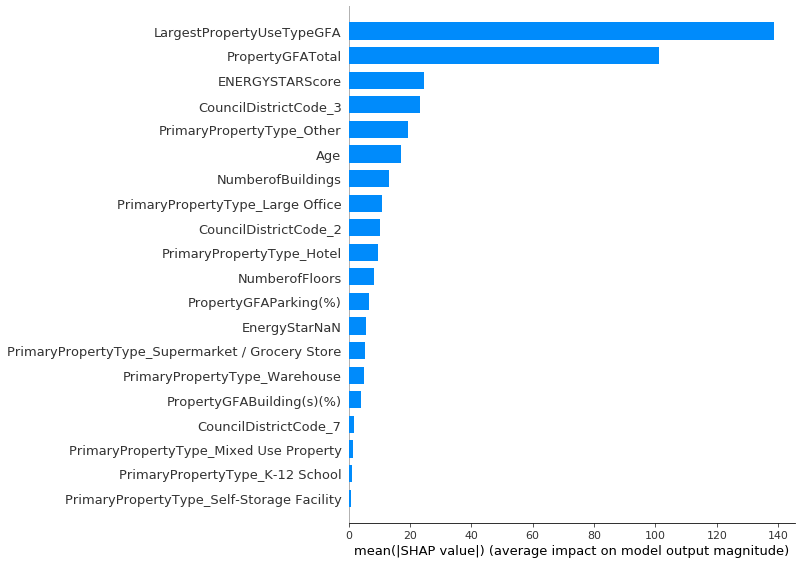

In [120]:
explainer = shap.TreeExplainer(gb, X_train)
shap_values = explainer.shap_values(X_test_tt, check_additivity=False)
shap.summary_plot(shap_values, X_test_tt, plot_type="bar")

In [72]:
feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance': gb.feature_importances_})
feature_importance = feature_importance.sort_values(by='importance', ascending=False)
feature_importance

,feature,importance
3,PropertyGFATotal,0.426454
6,LargestPropertyUseTypeGFA,0.173863
7,ENERGYSTARScore,0.068981
0,Age,0.050758
19,PrimaryPropertyType_Supermarket / Grocery Store,0.047919
2,NumberofFloors,0.043821
10,PrimaryPropertyType_Hotel,0.030101
15,PrimaryPropertyType_Other,0.029296
21,PrimaryPropertyType_Warehouse,0.023351
12,PrimaryPropertyType_Large Office,0.020068


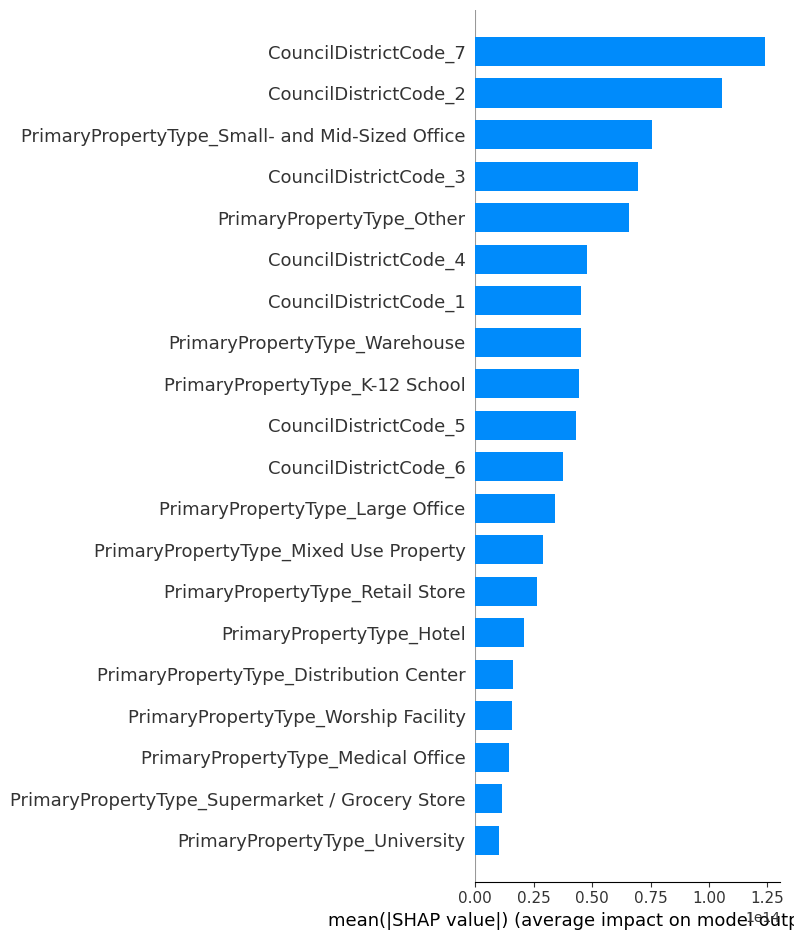

In [89]:
explainer_lr = shap.LinearExplainer(lr, X_train)
shap_values_lr = explainer_lr.shap_values(X_test)
shap.summary_plot(shap_values_lr, X_test, plot_type="bar")

In [80]:
explainer = shap.TreeExplainer(rf)

In [82]:
shap_values = shap.TreeExplainer(rf).shap_values(X_train)

In [83]:
shap_values

array([[-1.62807879e+00, -5.29829430e+00,  1.14224352e+00, ...,
        -3.80659545e-02, -6.68238644e-03,  1.33888086e-02],
       [ 7.72883583e+00, -5.12936308e+00,  1.14627704e+00, ...,
        -2.65333663e-02, -6.68238644e-03,  1.33888086e-02],
       [ 6.43422586e+00, -5.21320449e+00,  1.87797041e+00, ...,
        -3.70696415e-02, -6.68238644e-03,  2.40255725e-02],
       ...,
       [-3.77976190e-01, -5.27231112e+00,  1.75550999e+00, ...,
        -3.34379739e-02, -1.14655683e-02,  7.28397252e-02],
       [ 2.74497730e-01, -5.27525747e+00,  2.06621636e+00, ...,
        -3.34379739e-02, -1.14655683e-02,  1.33888086e-02],
       [ 2.78310545e-01, -5.23014661e+00,  2.05659688e+00, ...,
        -3.34379739e-02, -1.14655683e-02,  1.33888086e-02]])

In [94]:
np.clip(shap_values, 0, 100)

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.51048660e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.10650352e-02, 0.00000000e+00, 7.94167310e-01],
       [1.82387460e+01, 0.00000000e+00, 0.00000000e+00, ...,
        5.26376218e-03, 0.00000000e+00, 0.00000000e+00],
       ...,
       [9.10856923e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.53690049e-02, 0.00000000e+00, 0.00000000e+00],
       [1.92304002e+01, 0.00000000e+00, 0.00000000e+00, ...,
        2.75835440e-02, 0.00000000e+00, 5.02761083e-01],
       [1.25682305e+01, 0.00000000e+00, 0.00000000e+00, ...,
        1.71693608e-02, 0.00000000e+00, 0.00000000e+00]])

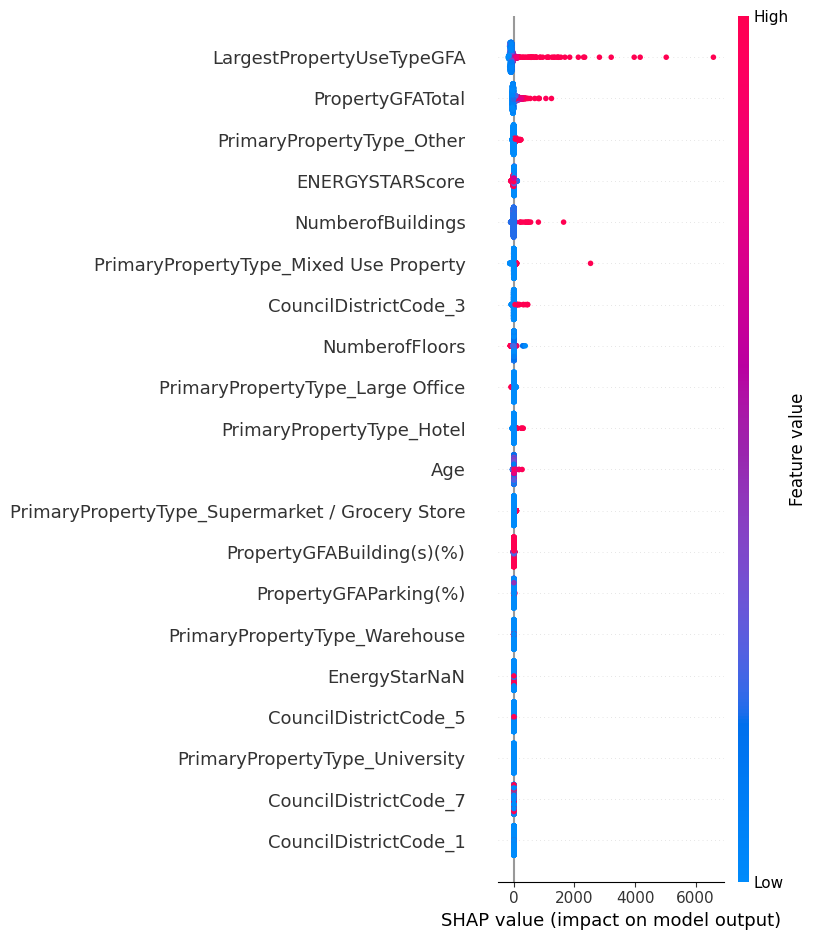

In [86]:
shap.summary_plot(shap_values, X_train)

In [99]:
shap.initjs()

In [101]:
i=5
shap.force_plot(explainer.expected_value, shap_values[i], 
                X_train.values[i], feature_names=X_train.columns)